# <center>HBP Analysis </center>
#### <center> Kenza Fliou - June 2024 <center> 

## IMPORT

In [3]:
#library
import HBP_dynamics_toolkit as HBP
import numpy as np
import yanat
import math
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import PySide2
import statsmodels.api as sm
from tqdm import tqdm
import scipy.io
import os
from visual_config import *
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import pdist, squareform
from collections import OrderedDict
import pickle
for font in font_manager.findSystemFonts("/home/kenza/Desktop/Data-fTRACT/Atkinson-Hyperlegible-Font-Print-and-Web-2020-0514"):
    font_manager.fontManager.addfont(font)

set_visual_style()

/home/kenza/anaconda3/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# data: Import HBP connectomes (5 level of resolution)
HBP_Dataset_path = '/home/kenza/Desktop/Data-fTRACT/d-ea46bcd6-d19b-479a-8d45-ecc486e3c8b1'
# data: path to Lausanne connectome consensus (matlab_file)
Lausanne_path = '/home/kenza/Desktop/Data-fTRACT/Consensus_mat/Consensus_Connectomes.mat'
warnings.filterwarnings("ignore")

## I - COMPUTE MODELS
The function `COMPUTE` computes or loads all the models from the Lausanne consensus dataset. Only the probability matrix from `ftract`, the Human Brain Project (HBP) dataset, is used.

The models used in this analysis are:
- "SC": Structural connectivity (Lausanne)
- "FC": Functional connectivity (Lausanne)
- "ED": Euclidean distance (Lausanne)
- "FL": Fiber Length (Lausanne)
- "LAM": Linear Attenuation Model calculated from "SC" (Lausanne) using spectral normalization (by default). The HBP library uses the α parameter that maximizes the Spearman correlation with the HBP `ftract` probability matrix.
- "CMY": Communicability calculated from "SC" (Lausanne)

The last two models were computed with the YANAT toolkit.


### a - Spectral normalization

In [5]:
models_spectral = HBP.COMPUTE(HBP_Dataset_path,Lausanne_path)
vectors_spectral = HBP.VECTOR(models_spectral,2)
spearman_spectral = HBP.SPEARMAN(models_spectral)

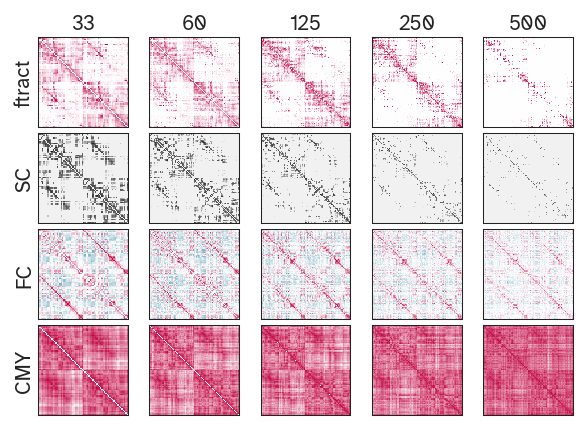

In [6]:
HBP.PLOT_HEATMAP(models_spectral)

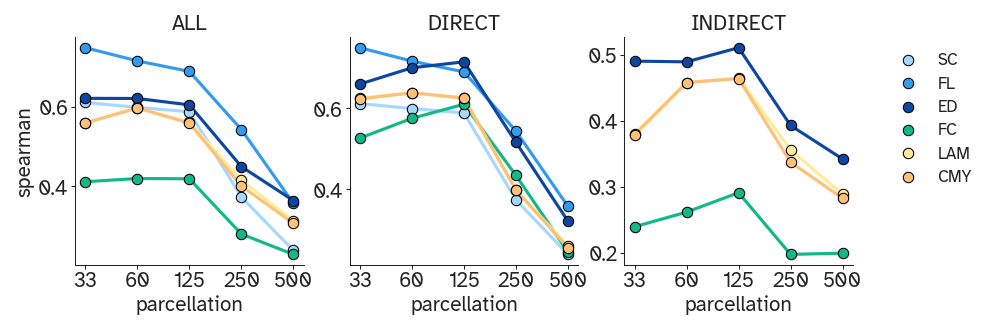

In [7]:
HBP.PLOT_SPEARMAN(spearman_spectral)

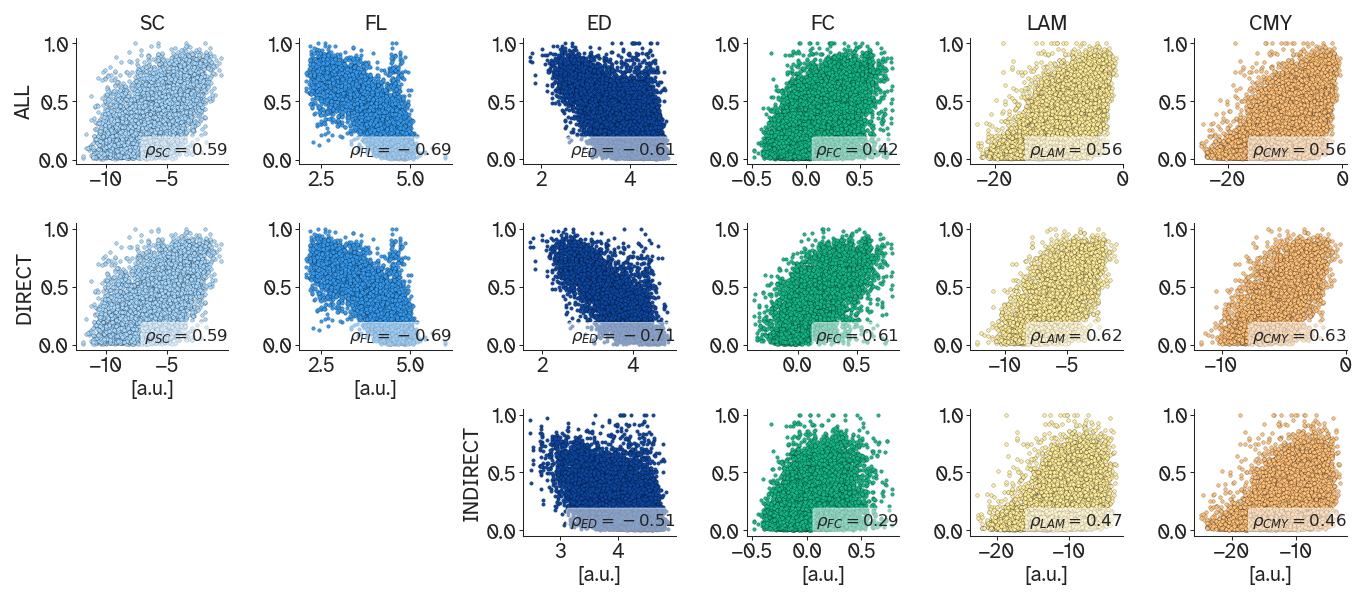

In [8]:
res='125'
HBP.SCATTERPLOT(vectors_spectral,spearman_spectral,res)

### b - Strength normalization - CMY

In [9]:
models_strength = HBP.COMPUTE(HBP_Dataset_path,Lausanne_path,yanat.utils.strength_normalization)
vectors_strength = HBP.VECTOR(models_strength,2)
spearman_strength = HBP.SPEARMAN(models_strength)

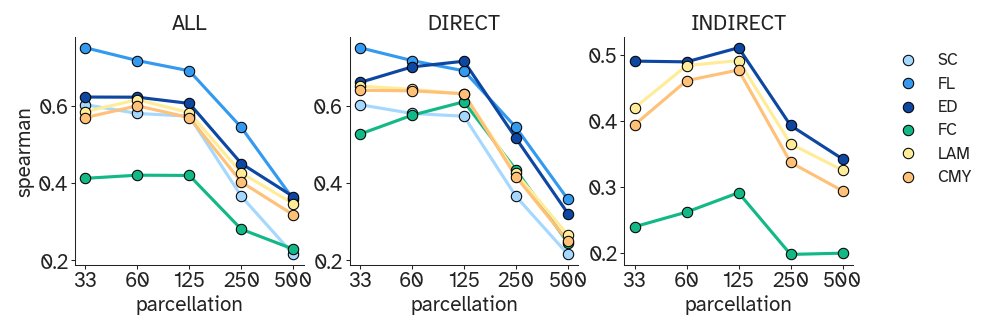

In [10]:
HBP.PLOT_SPEARMAN(spearman_strength)

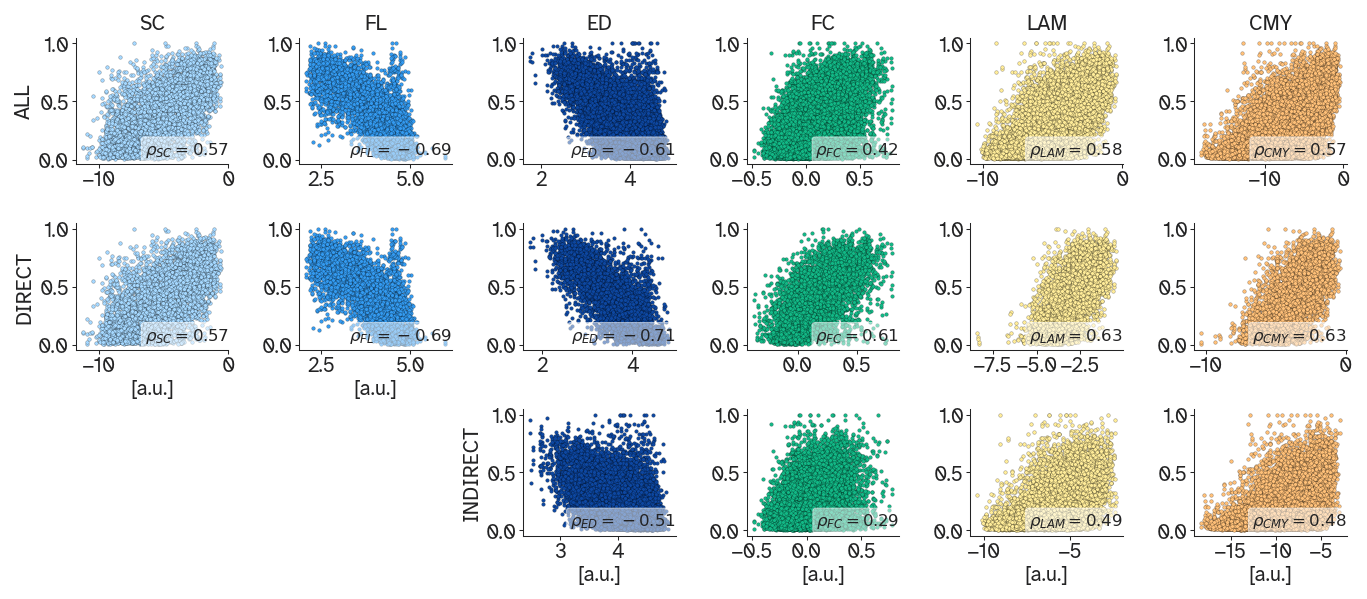

In [11]:
HBP.SCATTERPLOT(vectors_strength,spearman_strength,res)

### c - Compare normalization

In [12]:
SPEARMAN_STRENGTH = spearman_strength 
SPEARMAN_SPECTRAL = spearman_spectral

In [13]:
COMPARE_NORM_SPEARMAN = HBP.SPEARMAN_NORM(SPEARMAN_STRENGTH,SPEARMAN_SPECTRAL)

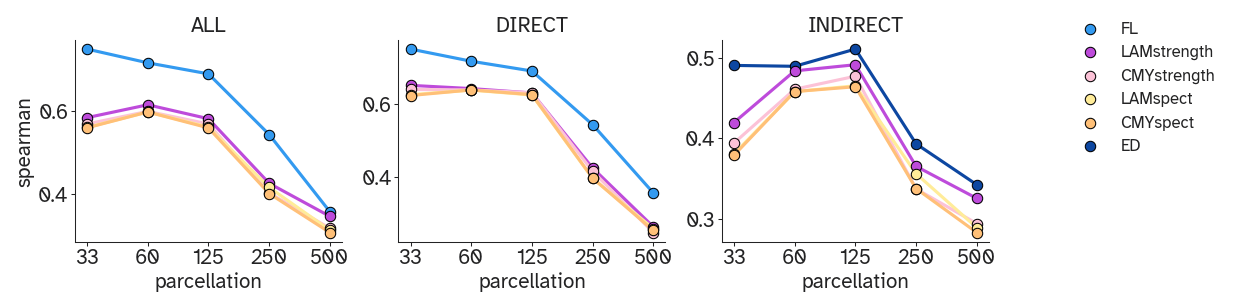

In [14]:
HBP.COMPARE_NORMALIZATION_PLOT_SPEARMAN(COMPARE_NORM_SPEARMAN)

In [15]:
COMPARE_NORM_VECTOR = HBP.VECTOR_NORM(vectors_strength,vectors_spectral)

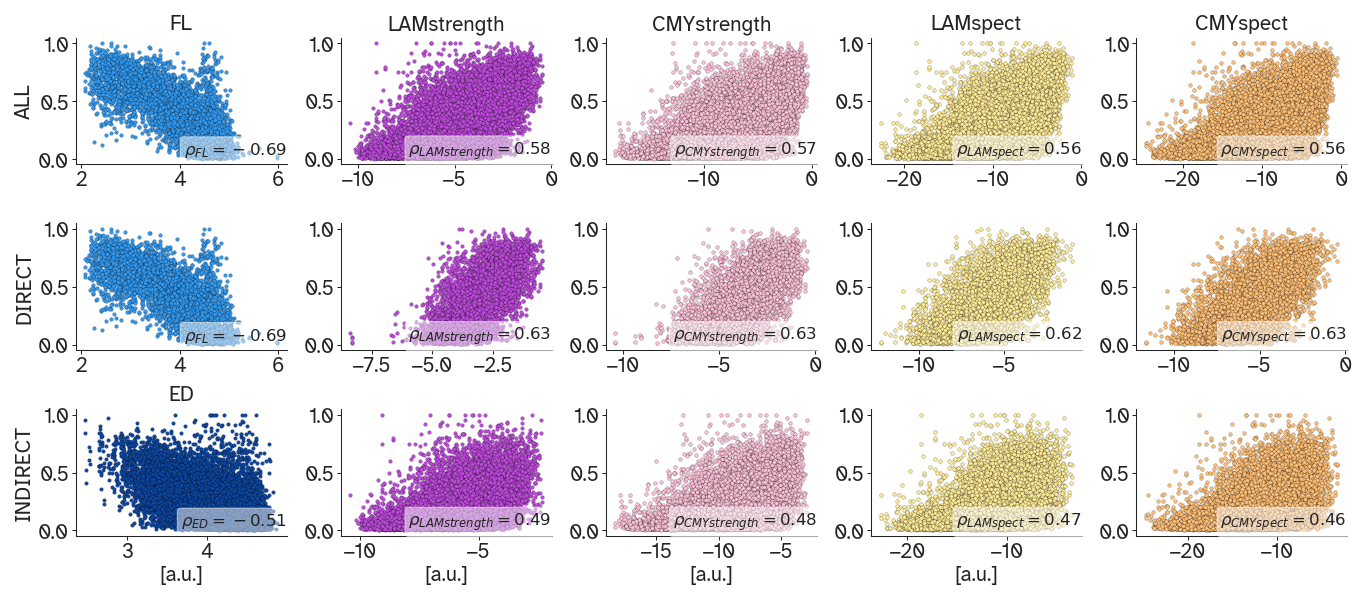

In [16]:
HBP.COMPARE_NORMALIZATION_SCATTERPLOT(COMPARE_NORM_VECTOR,COMPARE_NORM_SPEARMAN,'125')

### e - Spectral AND (then) strength

In [17]:
models_spectral_2normalization = HBP.COMPUTE_spectral_then_strength_norm(HBP_Dataset_path,Lausanne_path)
vectors_spectral_2normalization = HBP.VECTOR(models_spectral_2normalization,2)
spearman_spectral_2normalization = HBP.SPEARMAN(models_spectral_2normalization)

In [18]:
spearman_spectral_2normalization['ALL'][0]

,SC,FL,ED,FC,LAM,CMY
33,0.602168,-0.749366,-0.621907,0.411863,0.58415,0.568875
60,0.579495,-0.716207,-0.62153,0.420007,0.615119,0.599249
125,0.5724,-0.689611,-0.605432,0.41932,0.581513,0.568869
250,0.365343,-0.543405,-0.450065,0.280262,0.425848,0.402422
500,0.215316,-0.35739,-0.364569,0.228908,0.346248,0.31747


In [19]:
spearman_spectral_2normalization['DIRECT'][0]

,SC,FL,ED,FC,LAM,CMY
33,0.602168,-0.749366,-0.659572,0.526065,0.650527,0.639255
60,0.579495,-0.716207,-0.699763,0.574866,0.641713,0.638003
125,0.5724,-0.689611,-0.7145,0.609727,0.62976,0.630466
250,0.365343,-0.543405,-0.515576,0.43384,0.425274,0.416404
500,0.215316,-0.35739,-0.320873,0.244591,0.265038,0.249481


In [20]:
spearman_spectral_2normalization['INDIRECT'][0]

,ED,FC,LAM,CMY
33,-0.490338,0.239493,0.419376,0.393866
60,-0.48924,0.261724,0.48355,0.460755
125,-0.510647,0.291117,0.491204,0.476919
250,-0.392932,0.197662,0.364991,0.336968
500,-0.34215,0.199547,0.32518,0.29388


### d - Thresholding SC


In [21]:
SC_125_spectral = models_spectral[2]['SC']
ftract_125 = models_spectral[2]['ftract']

#### Applying different threshold on SC

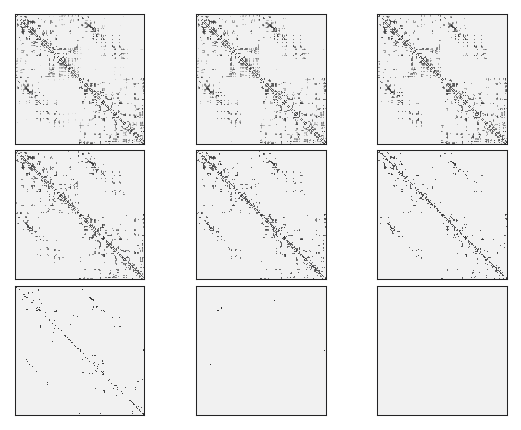

In [28]:
SC_color = sns.color_palette('light:'+HALF_BLACK, as_cmap=True)
colors = [DEEP_BLUE, 'white' ,RED]
cmap_name = 'deep_blue_white_red'
FC_color = LinearSegmentedColormap.from_list(cmap_name, colors)

# Defining threshold list
T = np.linspace(0,1,9)

SC_thresholded=[]
for t in T:
    SC_thresholded.append(HBP.SC_THRESHOLD(yanat.utils.log_minmax_normalize(SC_125_spectral),t))
    
color_dic = {"SC":SC_color,"ftract":FC_color,"FC":FC_color,"CMY":FC_color}
plot =  [["A","B","C"],["D","E","F"],["G","H","I"]]
fig, axes = plt.subplot_mosaic(plot,figsize=(10* CM, 7 * CM),dpi=150,)
    
for t,ax in zip(range(9),axes):
    sns.heatmap((SC_thresholded[t]),ax=axes[ax],
                      square=True,xticklabels=False,cmap=color_dic['SC'],
                    yticklabels=False,linewidths=0,rasterized=True,cbar=False)
fig.tight_layout(pad=0.3)
sns.despine(fig=fig, top=False, right=False, left=False, bottom=False)

In [37]:
SC_T_MODELS=[]
for sc_T in SC_thresholded:
    SC_T_MODELS.append(HBP.compute_models_thresholdSC(sc_T,ftract_125))

In [38]:
SPEARMAN_SC_T = HBP.SPEARMAN_SC_THRESHOLD(SC_T_MODELS,T)
SPEARMAN_SC_T['INDIRECT'][0]

,LAM,CMY
0.000,0.38833,0.172405
0.125,0.395382,0.182479
0.250,0.410043,0.216622
0.375,0.431003,0.253621
0.500,0.472696,0.320871
0.625,0.477587,0.389425
0.750,0.341856,0.309819
0.875,0.051503,0.034627
1.000,NaN,NaN


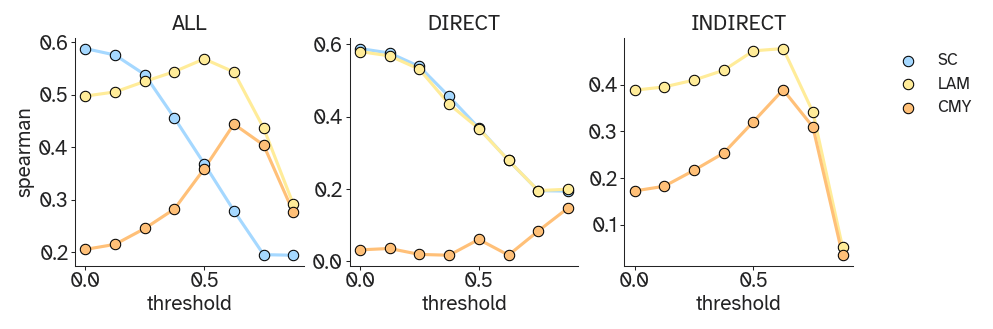

In [42]:
HBP.PLOT_SPEARMAN_SC_THRESHOLD(SPEARMAN_SC_T)